Fourth figure of the manuscript, showing Cross-correlation analyses. 
- Fitting results
- brain maps
- correlations of spatial parameter b with timescales for LFP and gamma

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
from scipy.stats import bootstrap, ttest_rel, false_discovery_control
import matplotlib.pyplot as plt
import mne
import nilearn
from nilearn import surface as nisurf

from mnitimescales import plots, utils

plots._set_font_params()

Imports and definitions:

In [3]:
stages = ["W", "N3", "R"]
stage_colors = {"W": "red", "N2": "cyan", "N3": "purple", "R": "green"}
title_dict = {"W": "Wake", "N2": "NREM2", "N3": "NREM3", "R": "REM"}
corr_type = "pearson"

# Paths
data_path = Path("F:\\MNIOpen")
sc_path = data_path.joinpath("Results", "test_sc_broadband")
sc_gamma_path = data_path.joinpath("Results", "test_sc_gamma")
tau_path = data_path.joinpath("Results", "timescales_broadband")
tau_gamma_path = data_path.joinpath("Results", "timescales_gamma")
fig_path = data_path.joinpath("Figures", "Fig_sc")
fig_path.mkdir(exist_ok=True, parents=True)

# Dataframe with data on broadband
df_sc_bb = {
    stage: pd.read_csv(sc_path.joinpath(f"sc_{stage}.csv"), index_col=0)
    for stage in stages
}
df_sc_gamma = {
    stage: pd.read_csv(sc_gamma_path.joinpath(f"sc_{stage}.csv"), index_col=0)
    for stage in stages
}

# Dataframe with timescales for all electrodes
df_timescales_bb = pd.read_csv(tau_path.joinpath("tau_stages.csv"), index_col=0)
df_timescales_gamma = pd.read_csv(tau_gamma_path.joinpath("tau_stages.csv"), index_col=0)

TODO: plots for gamma and broadband in all stages

In [ ]:
delta_d = 10
distances = np.arange(delta_d, 121, 10)
index = pd.MultiIndex.from_product(
    [list(df_sc_stages["W"]["region_1"].unique()), distances],
    names=["region", "distance"],
)
df_avg_d = pd.DataFrame(
    columns=["W", "N3", "R"],
    index=index,
)

for reg in df_avg_d.index.get_level_values("region").unique():
    for dist in distances:
        for stage in stages:

            df_avg_d.loc[(reg, dist), stage] = (
                df_sc_stages[stage]["corr"][
                    (
                        (df_sc_stages[stage]["region_1"] == reg)
                        | (df_sc_stages[stage]["region_2"] == reg)
                    )
                    & (df_sc_stages[stage]["dist"] <= dist + delta_d)
                    & (df_sc_stages[stage]["dist"] > dist - delta_d)
                ]
                .abs()
                .mean()
            )

df_avg_d.reset_index(inplace=True)

In [ ]:
df_rhos_d = pd.DataFrame(index=df_avg_d["distance"].unique(), columns=["rho", "rho_se", "pval"], dtype=float)

# Get average tau per MNI region
df_tau_stage_mni = utils.get_avg_tau_mni(
    df_timescales[df_timescales["stage"] == "R"].copy(), method="LME"
)

for dist in df_avg_d["distance"].unique():

    # print(f"Stage: {stage}, Param: {param}")

    # Get spatial parameter
    df_spa = df_avg_d[df_avg_d["distance"] == dist].set_index("region")
    df_spa = df_spa["R"].dropna()

    # Map coords
    map_coords_dist = map_coords.loc[
        list(df_spa.index.drop(["Amygdala", "Hippocampus"], errors="ignore") + "_lh")
        + list(df_spa.index.drop(["Amygdala", "Hippocampus"], errors="ignore") + "_rh")
    ]

    # Get correlation values
    rho, p_corr = utils.get_pcorr_mnia(
        df_tau_stage_mni.loc[df_spa.index],
        df_spa,
        map_coords_dist,
        method="vasa",
        corr_type="pearson",
        # nspins=0,
    )

    # df_rhos.loc[param, stage] = rho
    # df_pvals.loc[param, stage] = p_corr
    rho_boot = utils.get_rho_boot(
        df_tau_stage_mni.loc[df_spa.index],
        df_spa, corr_type="pearson", nboot=1000
    )

    df_rhos_d.loc[dist, "rho"] = rho
    df_rhos_d.loc[dist, "rho_se"] = rho_boot.standard_error
    df_rhos_d.loc[dist, "pval"] = p_corr

Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


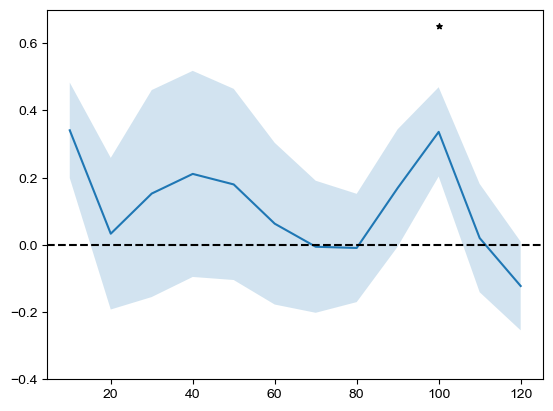

In [ ]:
plt.plot(df_rhos_d.index, df_rhos_d["rho"])
plt.fill_between(df_rhos_d.index, df_rhos_d["rho"] - df_rhos_d["rho_se"], df_rhos_d["rho"] + df_rhos_d["rho_se"], alpha=0.2)
sig_dist = df_rhos_d.index[false_discovery_control(df_rhos_d["pval"]) < 0.05]
plt.scatter(sig_dist, [0.65] * len(sig_dist), marker="*", c="k", s=16)
plt.axhline(0.0, color="k", ls="--")
plt.ylim(-0.4, 0.7)
plt.show()

In [ ]:
false_discovery_control(df_rhos_d["pval"])

array([0.078     , 0.624     , 0.274     , 0.189     , 0.189     ,
       0.552     , 0.8376    , 0.876     , 0.1968    , 0.048     ,
       0.906     , 0.63333333])